Import Libraries & Load NHANES Datasets

In [156]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display full columns
pd.set_option('display.max_columns', None)


In [157]:
# Load NHANES datasets (update the path as needed)
dr1iff = pd.read_sas("DR1IFF_L.xpt", format='xport')         # Individual food intake
drxfcd = pd.read_sas("DRXFCD_L.xpt", format='xport')         # Food descriptions
dr1tot = pd.read_sas("DR1TOT_L.xpt", format='xport')         # Total nutrients
insulin = pd.read_sas("INS_L.xpt", format='xport')           # Fasting insulin
ghb = pd.read_sas("GHB_L.xpt", format='xport')               # HbA1c
chol = pd.read_sas("TCHOL_L.xpt", format='xport')            # Cholesterol
hscrp = pd.read_sas("HSCRP_L.xpt", format='xport')           # C-reactive protein (optional)


In [158]:
print(pd.DataFrame(hscrp))

          SEQN       WTPH2YR  LBXHSCRP      LBDHRPLC
0     130378.0  5.604213e+04      1.78  5.397605e-79
1     130379.0  3.743571e+04      2.03  5.397605e-79
2     130380.0  8.532884e+04      5.62  5.397605e-79
3     130381.0  5.397605e-79       NaN           NaN
4     130382.0  5.963893e+04       NaN           NaN
...        ...           ...       ...           ...
8722  142306.0  5.397605e-79       NaN           NaN
8723  142307.0  6.899418e+04      4.30  5.397605e-79
8724  142308.0  5.397605e-79       NaN           NaN
8725  142309.0  4.628442e+04      0.53  5.397605e-79
8726  142310.0  5.325082e+04      5.70  5.397605e-79

[8727 rows x 4 columns]


In [146]:
# Merge food intake with description
merged = dr1iff.merge(drxfcd, left_on="DR1IFDCD", right_on="DRXFDCD", how="left")

# Convert bytes to lowercase strings (safe for mixed data types)
merged['desc_lower'] = merged['DRXFCSD'].apply(lambda x: x.decode('utf-8').lower() if isinstance(x, bytes) else str(x).lower())

# Define junk food keywords
junk_keywords = [
    'pizza', 'burger', 'soda', 'soft drink', 'french fries', 'fries', 'chips', 
    'cookies', 'cake', 'candy', 'ice cream', 'doughnut', 'fried chicken', 
    'milkshake', 'energy drink', 'chocolate', 'fast food', 'popcorn', 'bacon'
]

# Flag junk food items
merged['junk_food_flag'] = merged['desc_lower'].apply(
    lambda x: any(keyword in x for keyword in junk_keywords) if pd.notnull(x) else False
).astype(int)


In [161]:
import pandas as pd
import numpy as np

# Step 1: Load NHANES files
dr1iff = pd.read_sas("DR1IFF_L.xpt", format='xport')
drxfcd = pd.read_sas("DRXFCD_L.xpt", format='xport')
dr1tot = pd.read_sas("DR1TOT_L.xpt", format='xport')
ins = pd.read_sas("INS_L.xpt", format='xport')
ghb = pd.read_sas("GHB_L.xpt", format='xport')
tchol = pd.read_sas("TCHOL_L.xpt", format='xport')
hscrp = pd.read_sas("HSCRP_L.xpt", format='xport')

# Step 2: Merge food descriptions into Day 1 food intake
diet = dr1iff.merge(drxfcd[["DRXFDCD", "DRXFCSD"]], left_on="DR1IFDCD", right_on="DRXFDCD", how="left")

# Step 3: Decode byte strings to text
diet["DRXFCSD"] = diet["DRXFCSD"].apply(lambda x: x.decode("utf-8") if isinstance(x, bytes) else str(x))

# Step 4: Tag junk food items
junk_keywords = ["pizza", "burger", "fries", "chips", "cookie", "soda", "cake", "candy", "donut", "ice cream"]
diet["is_junk"] = diet["DRXFCSD"].str.lower().apply(lambda x: any(k in x for k in junk_keywords))

# Step 5: Calculate junk calories
diet["junk_kcal"] = diet["is_junk"] * diet["DR1IKCAL"]

# Step 6: Aggregate calories per person
junk_summary = diet.groupby("SEQN")[["DR1IKCAL", "junk_kcal"]].sum().reset_index()
junk_summary["junk_kcal_pct"] = 100 * junk_summary["junk_kcal"] / junk_summary["DR1IKCAL"]

# Step 7: Merge with Day 1 nutrient totals and lab biomarker files
merged = dr1tot.merge(junk_summary, on="SEQN", how="inner") \
    .merge(ins, on="SEQN", how="inner") \
    .merge(ghb, on="SEQN", how="inner") \
    .merge(tchol, on="SEQN", how="inner") \
    .merge(hscrp, on="SEQN", how="inner")

# Step 8: Select analysis variables
model_data = merged[[
    "junk_kcal_pct", "DR1TTFAT", "DR1TSUGR", "DR1TSODI", "DR1TPROT", "DR1TCARB",
    "LBXIN", "LBXGH", "LBXTC", "LBXHSCRP"
]].dropna()

# Step 9: Print descriptive statistics
print("\n📊 Descriptive Statistics (Day 1 Food + Day 1 Nutrients):")
print(model_data.describe())



📊 Descriptive Statistics (Day 1 Food + Day 1 Nutrients):
       junk_kcal_pct      DR1TTFAT      DR1TSUGR      DR1TSODI      DR1TPROT  \
count    2769.000000  2.769000e+03  2.769000e+03   2769.000000  2.769000e+03   
mean       16.582482  8.368623e+01  9.648484e+01   3092.329722  7.473258e+01   
std        18.242572  4.701241e+01  7.000338e+01   1682.990870  4.007864e+01   
min         0.000000  5.397605e-79  5.397605e-79     12.000000  5.397605e-79   
25%         0.000000  5.196000e+01  5.153000e+01   2005.000000  4.886000e+01   
50%        11.047786  7.633000e+01  8.212000e+01   2762.000000  6.710000e+01   
75%        26.112186  1.057900e+02  1.240800e+02   3792.000000  9.166000e+01   
max       100.000000  5.056200e+02  9.539000e+02  20006.000000  4.591500e+02   

           DR1TCARB        LBXIN        LBXGH        LBXTC     LBXHSCRP  
count  2.769000e+03  2769.000000  2769.000000  2769.000000  2769.000000  
mean   2.266070e+02    14.376746     5.714337   184.712170     3.634655  

In [147]:
merged.info

<bound method DataFrame.info of             SEQN        WTDRD1        WTDR2D  DR1ILINE  DR1DRSTZ  DR1EXMER  \
0       130378.0  61366.555827  70554.222162       1.0       1.0      73.0   
1       130378.0  61366.555827  70554.222162       2.0       1.0      73.0   
2       130378.0  61366.555827  70554.222162       3.0       1.0      73.0   
3       130378.0  61366.555827  70554.222162       4.0       1.0      73.0   
4       130378.0  61366.555827  70554.222162       5.0       1.0      73.0   
...          ...           ...           ...       ...       ...       ...   
100111  142310.0  47870.215680  51601.585149      14.0       1.0      89.0   
100112  142310.0  47870.215680  51601.585149      15.0       1.0      89.0   
100113  142310.0  47870.215680  51601.585149      16.0       1.0      89.0   
100114  142310.0  47870.215680  51601.585149      17.0       1.0      89.0   
100115  142310.0  47870.215680  51601.585149      18.0       1.0      89.0   

        DRABF  DRDINT  DR1DBIH 

In [162]:
import statsmodels.formula.api as smf

# ---- OLS Regressions ----
ols_models = {
    "Insulin": smf.ols("LBXIN ~ junk_kcal_pct + DR1TTFAT + DR1TSUGR + DR1TSODI + DR1TPROT + DR1TCARB", data=model_data).fit(),
    "HbA1c": smf.ols("LBXGH ~ junk_kcal_pct + DR1TTFAT + DR1TSUGR + DR1TSODI + DR1TPROT + DR1TCARB", data=model_data).fit(),
    "Cholesterol": smf.ols("LBXTC ~ junk_kcal_pct + DR1TTFAT + DR1TSUGR + DR1TSODI + DR1TPROT + DR1TCARB", data=model_data).fit(),
    "CRP": smf.ols("LBXHSCRP ~ junk_kcal_pct + DR1TTFAT + DR1TSUGR + DR1TSODI + DR1TPROT + DR1TCARB", data=model_data).fit()
}

# Display OLS results
for name, model in ols_models.items():
    print(f"\n📈 OLS Regression Results: {name}")
    print(model.summary())

# ---- Logistic Regressions ----
# Step 1: Create binary outcome variables
model_data["high_insulin"] = (model_data["LBXIN"] > 20).astype(int)
model_data["prediabetes"] = (model_data["LBXGH"] >= 5.7).astype(int)
model_data["high_crp"] = (model_data["LBXHSCRP"] >= 3).astype(int)

# Step 2: Logistic regression models
logit_models = {
    "High Insulin": smf.logit("high_insulin ~ junk_kcal_pct + DR1TTFAT + DR1TSUGR + DR1TSODI + DR1TPROT + DR1TCARB", data=model_data).fit(),
    "Prediabetes": smf.logit("prediabetes ~ junk_kcal_pct + DR1TTFAT + DR1TSUGR + DR1TSODI + DR1TPROT + DR1TCARB", data=model_data).fit(),
    "High CRP": smf.logit("high_crp ~ junk_kcal_pct + DR1TTFAT + DR1TSUGR + DR1TSODI + DR1TPROT + DR1TCARB", data=model_data).fit()
}

# Display logistic regression results
for name, model in logit_models.items():
    print(f"\n🔍 Logistic Regression Results: {name}")
    print(model.summary())



📈 OLS Regression Results: Insulin
                            OLS Regression Results                            
Dep. Variable:                  LBXIN   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.709
Date:                Thu, 24 Apr 2025   Prob (F-statistic):              0.115
Time:                        04:52:09   Log-Likelihood:                -12575.
No. Observations:                2769   AIC:                         2.516e+04
Df Residuals:                    2762   BIC:                         2.520e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept  

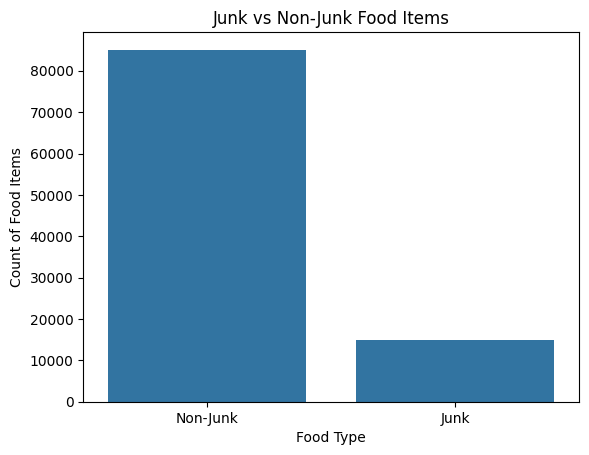

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=merged, x='junk_food_flag')
plt.title('Junk vs Non-Junk Food Items')
plt.xticks([0, 1], ['Non-Junk', 'Junk'])
plt.ylabel('Count of Food Items')
plt.xlabel('Food Type')
plt.show()


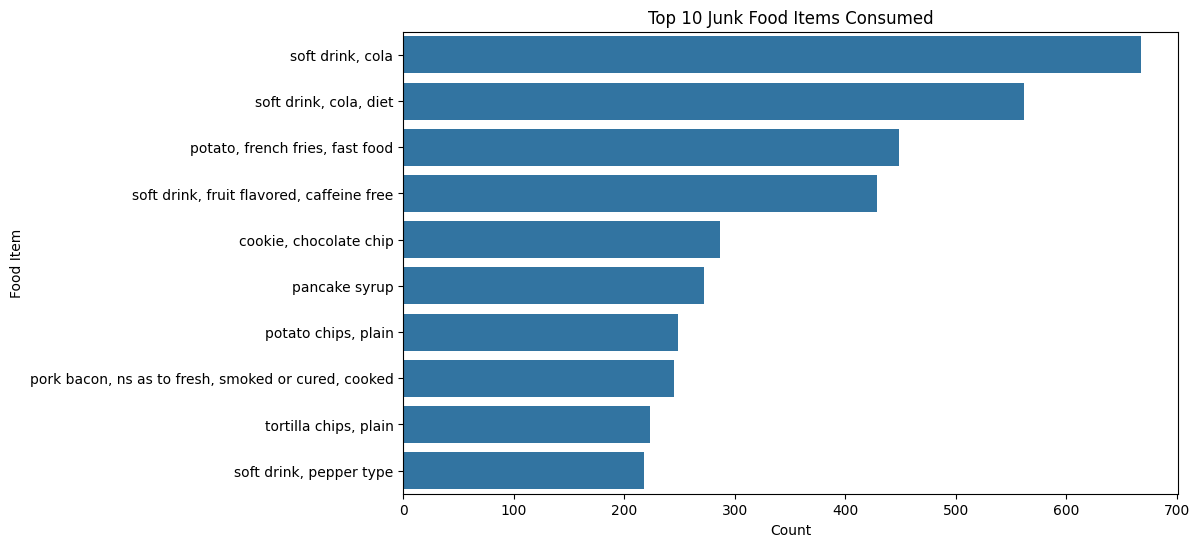

In [95]:
top_junk = merged[merged['junk_food_flag'] == 1]['desc_lower'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_junk.values, y=top_junk.index)
plt.title("Top 10 Junk Food Items Consumed")
plt.xlabel("Count")
plt.ylabel("Food Item")
plt.show()


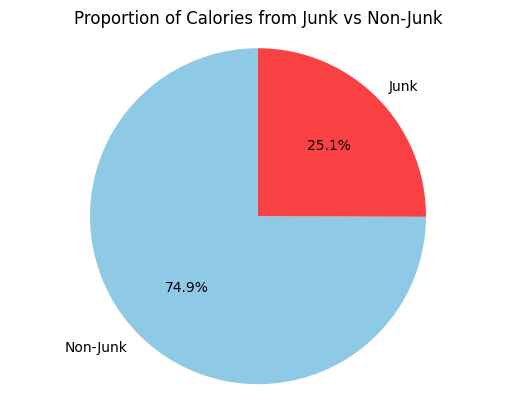

In [96]:
junk_kcal = merged.groupby('junk_food_flag')['DR1IKCAL'].sum()

plt.pie(junk_kcal, labels=['Non-Junk', 'Junk'], autopct='%1.1f%%', startangle=90, colors=['#8ecae6', '#f94144'])
plt.title('Proportion of Calories from Junk vs Non-Junk')
plt.axis('equal')
plt.show()


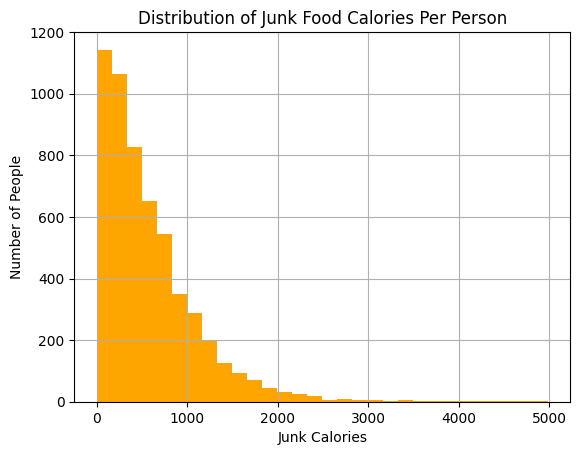

In [97]:
junk_summary['junk_kcal'].hist(bins=30, color='orange')
plt.title('Distribution of Junk Food Calories Per Person')
plt.xlabel('Junk Calories')
plt.ylabel('Number of People')
plt.show()


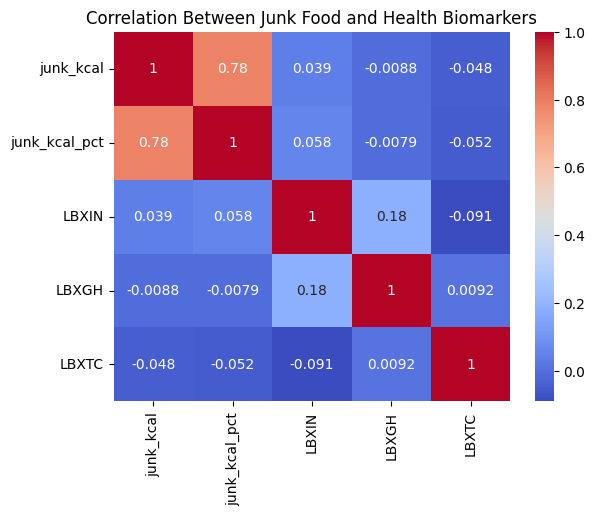

In [98]:
sns.heatmap(df_clean[['junk_kcal', 'junk_kcal_pct', 'LBXIN', 'LBXGH', 'LBXTC']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Junk Food and Health Biomarkers')
plt.show()


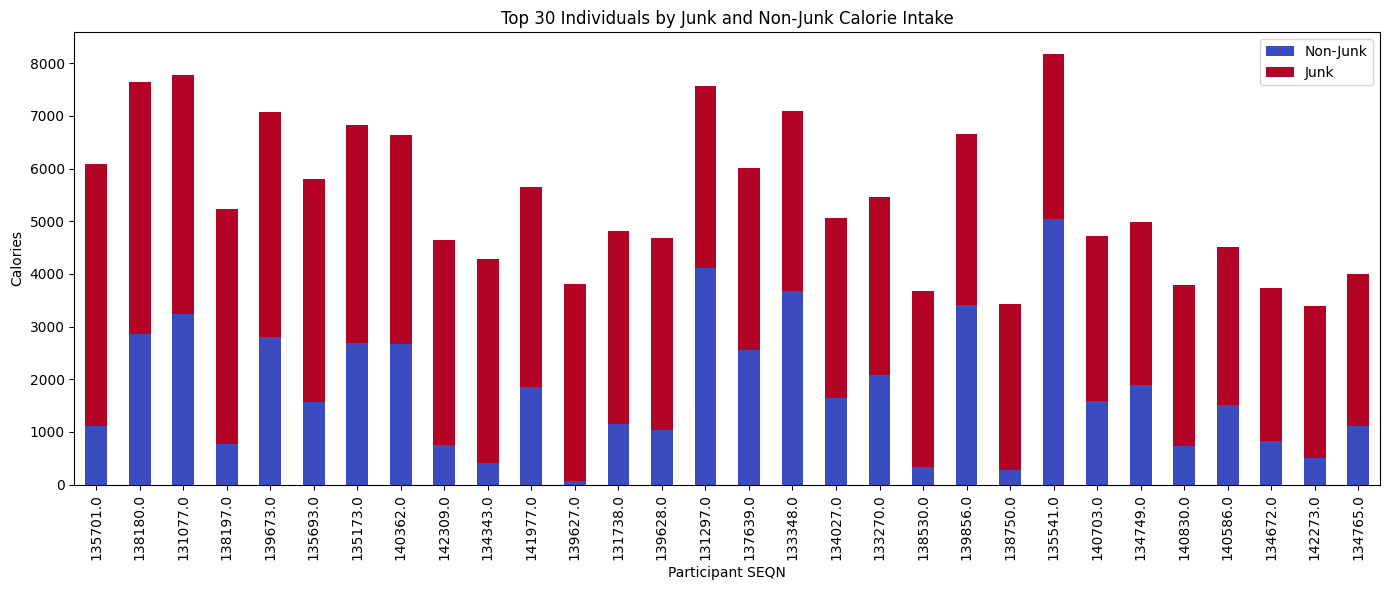

In [99]:
import matplotlib.pyplot as plt

# Total calories per person (grouped)
cal_data = merged.groupby(['SEQN', 'junk_food_flag'])['DR1IKCAL'].sum().unstack().fillna(0)
cal_data.columns = ['Non-Junk', 'Junk']

# Plot
cal_data.sort_values('Junk', ascending=False).head(30).plot(kind='bar', stacked=True, figsize=(14,6), colormap='coolwarm')
plt.title('Top 30 Individuals by Junk and Non-Junk Calorie Intake')
plt.xlabel('Participant SEQN')
plt.ylabel('Calories')
plt.tight_layout()
plt.show()


In [100]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


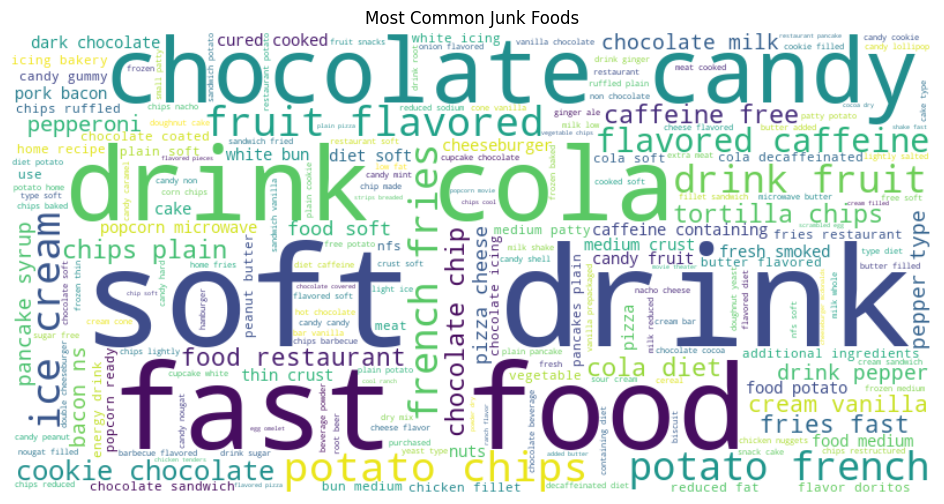

In [101]:
from wordcloud import WordCloud

text = " ".join(merged[merged['junk_food_flag'] == 1]['desc_lower'].dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Junk Foods")
plt.show()


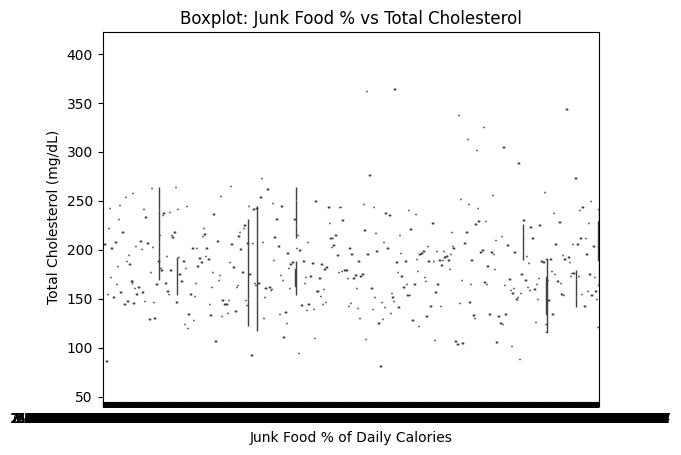

In [102]:
sns.boxplot(x='junk_kcal_pct', y='LBXTC', data=df_clean)
plt.title("Boxplot: Junk Food % vs Total Cholesterol")
plt.xlabel("Junk Food % of Daily Calories")
plt.ylabel("Total Cholesterol (mg/dL)")
plt.show()


In [103]:
pip install plotly


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [104]:
import plotly.express as px

fig = px.scatter(df_clean, x='junk_kcal_pct', y='LBXIN',
                 color='LBXGH', size='LBXTC',
                 hover_data=['SEQN'],
                 title='Junk Food % vs Insulin with HbA1c and Cholesterol Indicators')
fig.show()


In [105]:
# Summarize total junk food calories and grams per person (SEQN)
junk_summary = merged[merged['junk_food_flag'] == 1].groupby('SEQN').agg({
    'DR1IKCAL': 'sum',
    'DR1IGRMS': 'sum'
}).rename(columns={'DR1IKCAL': 'junk_kcal', 'DR1IGRMS': 'junk_grams'}).reset_index()


In [106]:
print(insulin.columns.tolist())


['SEQN', 'WTSAF2YR', 'LBXIN', 'LBDINSI', 'LBDINLC']


In [107]:
print(junk_summary)

          SEQN  junk_kcal  junk_grams
0     130378.0      812.0      333.00
1     130379.0      860.0      252.38
2     130381.0      298.0      236.00
3     130386.0      812.0      288.00
4     130387.0      474.0     1127.00
...        ...        ...         ...
5526  142302.0      666.0      195.00
5527  142304.0      723.0      723.00
5528  142307.0      111.0       30.00
5529  142309.0     3903.0     1911.00
5530  142310.0      425.0      110.00

[5531 rows x 3 columns]


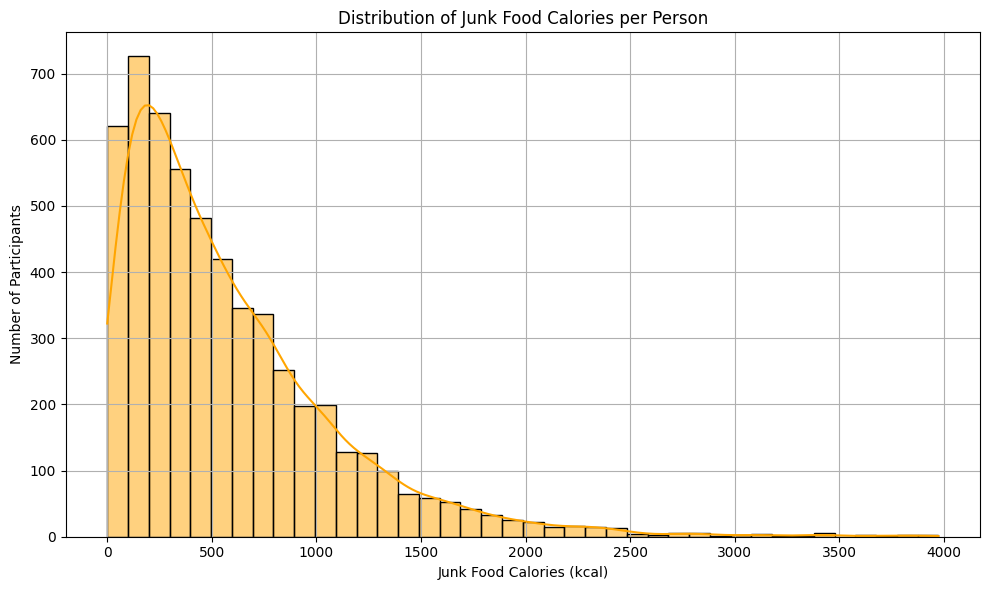

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Filter out extremely high values for cleaner visualization
filtered_summary = junk_summary[junk_summary['junk_kcal'] < 4000]

# Plot: Histogram of junk food calories
plt.figure(figsize=(10, 6))
sns.histplot(filtered_summary['junk_kcal'], bins=40, kde=True, color='orange')
plt.title("Distribution of Junk Food Calories per Person")
plt.xlabel("Junk Food Calories (kcal)")
plt.ylabel("Number of Participants")
plt.grid(True)
plt.tight_layout()
plt.show()


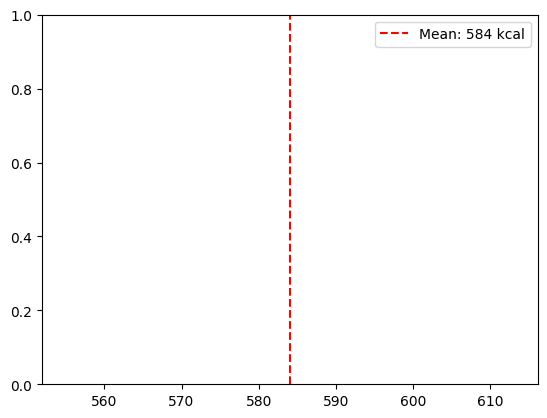

In [109]:
mean_val = junk_summary['junk_kcal'].mean()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.0f} kcal')
plt.legend()


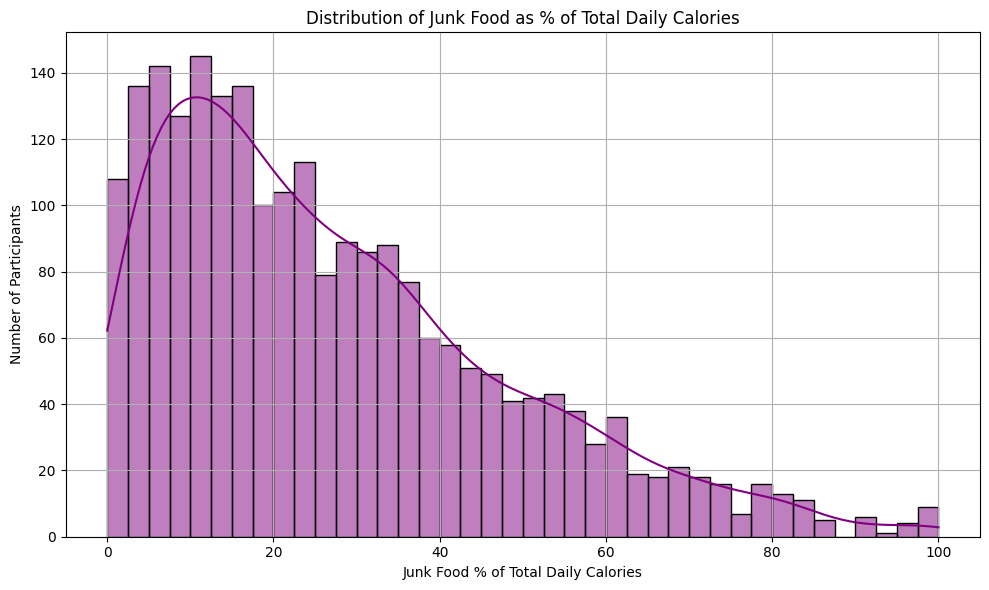

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Only include realistic values (0–100%)
filtered_df = df_clean[(df_clean['junk_kcal_pct'] >= 0) & (df_clean['junk_kcal_pct'] <= 100)]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['junk_kcal_pct'], bins=40, kde=True, color='purple')
plt.title("Distribution of Junk Food as % of Total Daily Calories")
plt.xlabel("Junk Food % of Total Daily Calories")
plt.ylabel("Number of Participants")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\parve\AppData\Local\Temp\ipykernel_7856\4003353827.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




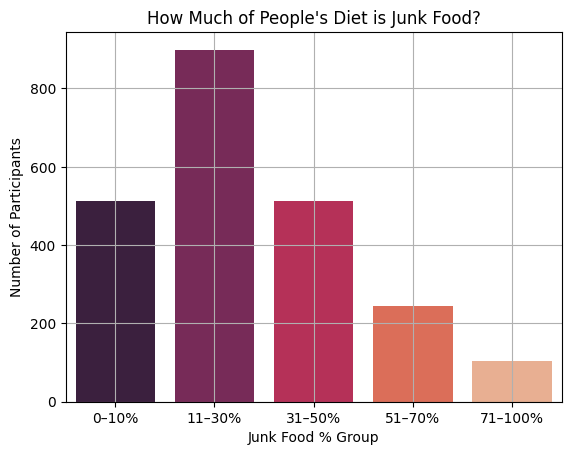

In [111]:
# Grouping
filtered_df['junk_group'] = pd.cut(
    filtered_df['junk_kcal_pct'],
    bins=[0, 10, 30, 50, 70, 100],
    labels=['0–10%', '11–30%', '31–50%', '51–70%', '71–100%']
)

# Countplot
sns.countplot(data=filtered_df, x='junk_group', palette='rocket')
plt.title("How Much of People's Diet is Junk Food?")
plt.xlabel("Junk Food % Group")
plt.ylabel("Number of Participants")
plt.grid(True)
plt.show()


In [113]:
if 'LBXIN' in df.columns:
    df = df.drop(columns=['LBXIN'])

df = df.merge(insulin[['SEQN', 'LBXIN']], on='SEQN', how='left')


In [115]:
# Drop existing columns if already merged
for col in ['LBXGH', 'LBXTC', 'LBXHSCRP']:
    if col in df.columns:
        df = df.drop(columns=[col])

# Merge the cleaned biomarkers
df = df.merge(ghb[['SEQN', 'LBXGH']], on='SEQN', how='left')       # HbA1c
df = df.merge(chol[['SEQN', 'LBXTC']], on='SEQN', how='left')     # Cholesterol
df = df.merge(hscrp[['SEQN', 'LBXHSCRP']], on='SEQN', how='left') # CRP


In [116]:
df_clean = df.dropna(subset=['LBXIN', 'LBXGH', 'LBXTC'])


In [120]:
# Total number of participants before cleaning
before_rows = df.shape[0]

# Total number of participants after dropping missing biomarker values
after_rows = df_clean.shape[0]

# Calculate how many were dropped
dropped_rows = before_rows - after_rows

# Print summary
print(f"Participants before cleaning: {before_rows}")
print(f"Participants after cleaning : {after_rows}")
print(f"Dropped due to missing LBXIN / LBXGH / LBXTC: {dropped_rows}")


Participants before cleaning: 5531
Participants after cleaning : 2273
Dropped due to missing LBXIN / LBXGH / LBXTC: 3258


In [121]:
print(df_clean)

          SEQN  junk_kcal  junk_grams  DR1TKCAL  DR1TPROT  DR1TCARB  DR1TSUGR  \
0     130378.0      812.0      333.00    1740.0     80.46    169.66     43.71   
1     130379.0      860.0      252.38    2741.0     86.45    314.86    113.58   
3     130386.0      812.0      288.00    2422.0    132.41    207.53     37.89   
9     130398.0      193.0      403.00    1109.0     32.42    195.50     82.65   
14    130404.0      494.0      208.83    1879.0     62.49    170.05     30.05   
...        ...        ...         ...       ...       ...       ...       ...   
5521  142295.0      749.0      924.00    1652.0     51.63    262.53    195.65   
5523  142299.0      267.0       51.00    2242.0     91.44    214.03     73.75   
5524  142300.0      575.0      222.50    2768.0    123.93    339.15    100.23   
5525  142301.0      447.0      178.00    1456.0     65.40    217.01     74.97   
5529  142309.0     3903.0     1911.00    4651.0    206.87    531.11    102.17   

      DR1TTFAT  LBXIN_x  LB

In [122]:
# Drop rows with missing biomarker data and make a real copy
df_clean = df.dropna(subset=['LBXIN', 'LBXGH', 'LBXTC']).copy()

# Now safely add percent of daily calories from junk food
df_clean['junk_kcal_pct'] = (df_clean['junk_kcal'] / df_clean['DR1TKCAL']) * 100


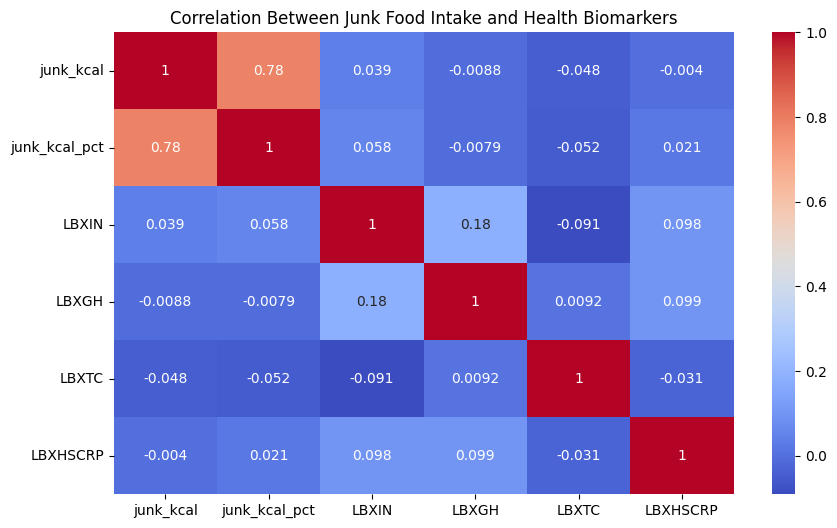

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant variables
correlation_data = df_clean[['junk_kcal', 'junk_kcal_pct', 'LBXIN', 'LBXGH', 'LBXTC', 'LBXHSCRP']]

# Compute and plot correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Junk Food Intake and Health Biomarkers")
plt.show()


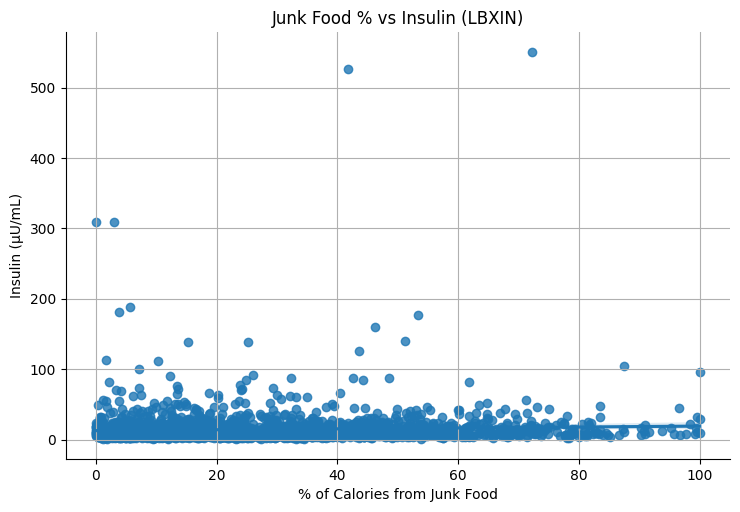

In [130]:
# Junk % vs Insulin
sns.lmplot(data=df_clean, x='junk_kcal_pct', y='LBXIN', height=5, aspect=1.5)
plt.title('Junk Food % vs Insulin (LBXIN)')
plt.xlabel('% of Calories from Junk Food')
plt.ylabel('Insulin (μU/mL)')
plt.grid(True)
plt.show()


In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


#Linear Regression Results
def run_regression(x_var, y_var, label):
    X = sm.add_constant(df_clean[[x_var]])
    y = df_clean[y_var]
    model = sm.OLS(y, X).fit()
    print(f"\n--- Linear Regression: {label} ---")
    print(model.summary())

run_regression('junk_kcal_pct', 'LBXIN', 'Junk % vs Insulin')
run_regression('junk_kcal_pct', 'LBXGH', 'Junk % vs HbA1c')
run_regression('junk_kcal_pct', 'LBXTC', 'Junk % vs Cholesterol')
run_regression('junk_kcal_pct', 'LBXHSCRP', 'Junk % vs Inflammation')



--- Linear Regression: Junk % vs Insulin ---
                            OLS Regression Results                            
Dep. Variable:                  LBXIN   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.594
Date:                Wed, 16 Apr 2025   Prob (F-statistic):            0.00590
Time:                        00:31:01   Log-Likelihood:                -10378.
No. Observations:                2273   AIC:                         2.076e+04
Df Residuals:                    2271   BIC:                         2.077e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------


In [136]:

# Updated Scatter Plot Function
def scatter_plot(x, y, label):
    sns.lmplot(
        data=df_clean,
        x=x,
        y=y,
        height=5,
        aspect=1.5,
        scatter_kws={'alpha': 0.4},
        line_kws={'color': 'red'}  # 🔴 Red regression line
    )
    plt.title(f'{x} vs {label}')
    plt.xlabel('% of Calories from Junk Food')
    plt.ylabel(label)
    plt.grid(True)
    plt.show()


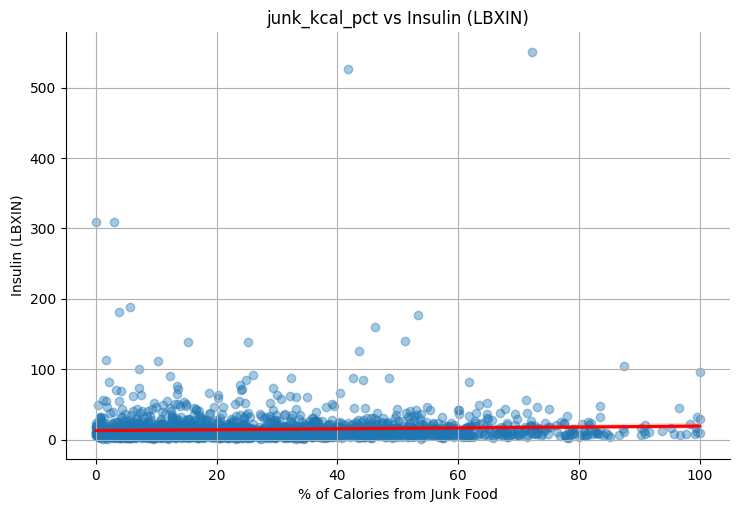

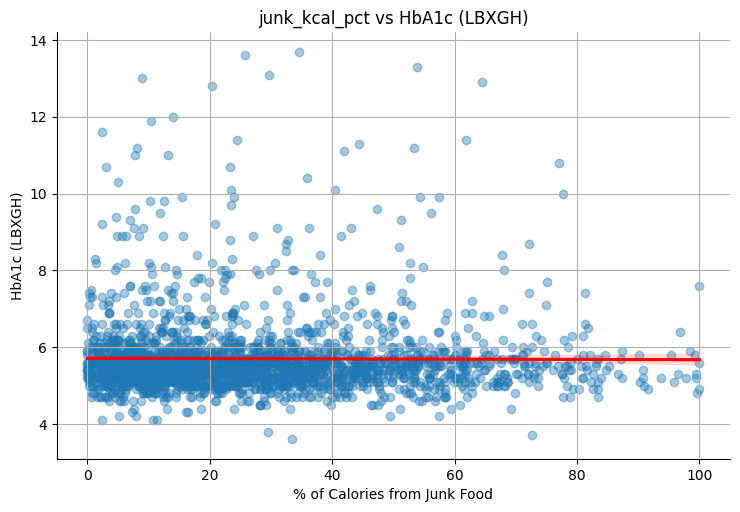

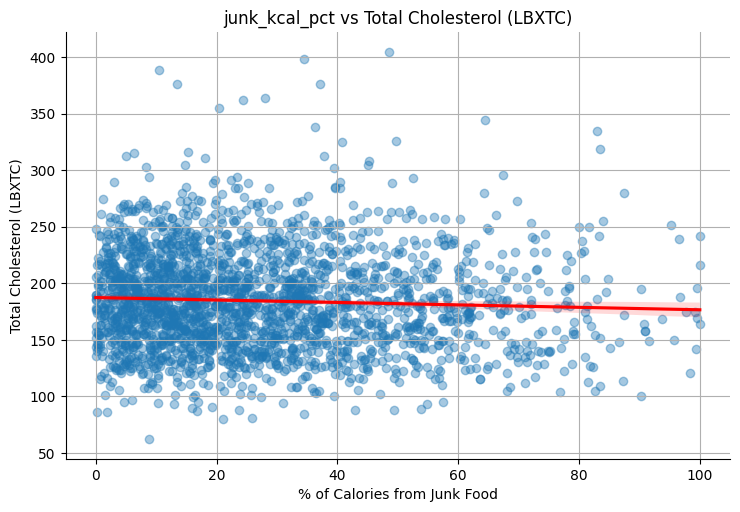

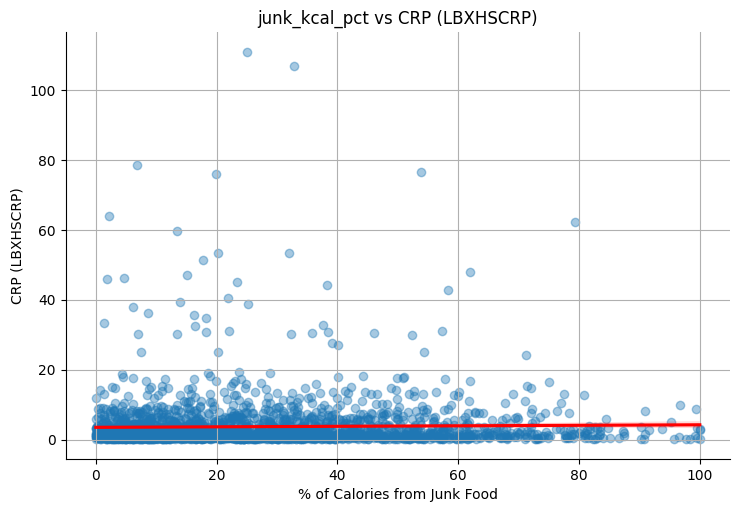

In [137]:
scatter_plot('junk_kcal_pct', 'LBXIN', 'Insulin (LBXIN)')
scatter_plot('junk_kcal_pct', 'LBXGH', 'HbA1c (LBXGH)')
scatter_plot('junk_kcal_pct', 'LBXTC', 'Total Cholesterol (LBXTC)')
scatter_plot('junk_kcal_pct', 'LBXHSCRP', 'CRP (LBXHSCRP)')


In [138]:
# Summary stats
df_clean[['junk_kcal', 'junk_kcal_pct', 'LBXIN', 'LBXGH', 'LBXTC']].describe()


junk_kcal  junk_kcal_pct        LBXIN        LBXGH        LBXTC
count  2.273000e+03   2.273000e+03  2273.000000  2273.000000  2273.000000
mean   5.756045e+02   2.738198e+01    14.448821     5.701188   184.434668
std    5.570153e+02   2.081913e+01    23.305155     1.005317    43.562246
min    5.397605e-79   2.161636e-80     0.350000     3.600000    62.000000
25%    1.910000e+02   1.096394e+01     6.090000     5.200000   153.000000
50%    4.190000e+02   2.269231e+01     9.580000     5.500000   181.000000
75%    7.860000e+02   3.915581e+01    15.970000     5.800000   211.000000
max    4.988000e+03   1.000000e+02   551.100000    13.700000   405.000000

In [127]:
# Correlation between junk food % and biomarkers
correlations = df_clean[['junk_kcal_pct', 'LBXIN', 'LBXGH', 'LBXTC']].corr()
print("Correlation matrix (Pearson):")
print(correlations)


Correlation matrix (Pearson):
               junk_kcal_pct     LBXIN     LBXGH     LBXTC
junk_kcal_pct       1.000000  0.057730 -0.007855 -0.051670
LBXIN               0.057730  1.000000  0.182438 -0.091134
LBXGH              -0.007855  0.182438  1.000000  0.009233
LBXTC              -0.051670 -0.091134  0.009233  1.000000


In [128]:
!pip install statsmodels



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [140]:
import statsmodels.api as sm


In [141]:
import statsmodels.api as sm

# Function to run and print regression results
def run_regression(x_var, y_var, label):
    X = df_clean[[x_var]]
    X = sm.add_constant(X)  # adds intercept
    y = df_clean[y_var]
    model = sm.OLS(y, X).fit()
    print(f"\nLinear Regression: {label}")
    print(model.summary())

# Run regression for each biomarker
run_regression('junk_kcal_pct', 'LBXIN', 'Junk Food % vs Insulin')
run_regression('junk_kcal_pct', 'LBXGH', 'Junk Food % vs HbA1c')
run_regression('junk_kcal_pct', 'LBXTC', 'Junk Food % vs Total Cholesterol')



Linear Regression: Junk Food % vs Insulin
                            OLS Regression Results                            
Dep. Variable:                  LBXIN   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.594
Date:                Wed, 16 Apr 2025   Prob (F-statistic):            0.00590
Time:                        01:19:09   Log-Likelihood:                -10378.
No. Observations:                2273   AIC:                         2.076e+04
Df Residuals:                    2271   BIC:                         2.077e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
con

In [142]:
import statsmodels.api as sm

# Function to run OLS regression
def run_ols(dependent_var):
    X = df_clean['junk_kcal_pct']
    y = df_clean[dependent_var]
    X = sm.add_constant(X)  # adds intercept
    model = sm.OLS(y, X).fit()
    print(f"\n--- Regression: junk_kcal_pct vs {dependent_var} ---")
    print(model.summary())
    return model

# Run regressions for each biomarker
model_insulin = run_ols('LBXIN')
model_hba1c = run_ols('LBXGH')
model_chol = run_ols('LBXTC')
model_crp = run_ols('LBXHSCRP')  # if CRP is already merged



--- Regression: junk_kcal_pct vs LBXIN ---
                            OLS Regression Results                            
Dep. Variable:                  LBXIN   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.594
Date:                Sat, 19 Apr 2025   Prob (F-statistic):            0.00590
Time:                        12:26:48   Log-Likelihood:                -10378.
No. Observations:                2273   AIC:                         2.076e+04
Df Residuals:                    2271   BIC:                         2.077e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
co

In [151]:
import pandas as pd

# Load NHANES datasets
dr1iff = pd.read_sas("DR1IFF_L.xpt", format='xport')       # Individual food intake
dr1tot = pd.read_sas("DR1TOT_L.xpt", format='xport')       # Total daily nutrient intake
drxfcd = pd.read_sas("DRXFCD_L.xpt", format='xport')       # Food description codes

# Lab files (biomarkers)
ins = pd.read_sas("INS_L.xpt", format='xport')             # Insulin (LBXIN)
ghb = pd.read_sas("GHB_L.xpt", format='xport')             # HbA1c (LBXGH)
chol = pd.read_sas("TCHOL_L.xpt", format='xport')          # Total Cholesterol (LBXTC)
hscrp = pd.read_sas("HSCRP_L.xpt", format='xport')         # CRP (LBXHSCRP)

# Decode food descriptions
drxfcd['desc_lower'] = drxfcd['DRXFCSD'].apply(lambda x: x.decode('utf-8').lower() if isinstance(x, bytes) else str(x).lower())

# Merge food descriptions with food intake data
merged = dr1iff.merge(drxfcd, left_on="DR1IFDCD", right_on="DRXFDCD", how="left")

# Define junk food keywords
junk_keywords = [
    'pizza', 'burger', 'soda', 'soft drink', 'french fries', 'fries', 'chips',
    'cookies', 'cake', 'candy', 'ice cream', 'doughnut', 'fried chicken',
    'milkshake', 'energy drink', 'chocolate', 'fast food', 'popcorn', 'bacon'
]

# Flag junk food items
merged['junk_food_flag'] = merged['desc_lower'].apply(
    lambda x: any(keyword in x for keyword in junk_keywords) if pd.notnull(x) else False
).astype(int)

# Summarize junk food per individual
junk_summary = merged[merged['junk_food_flag'] == 1].groupby('SEQN').agg({
    'DR1IKCAL': 'sum',
    'DR1IGRMS': 'sum'
}).rename(columns={'DR1IKCAL': 'junk_kcal', 'DR1IGRMS': 'junk_grams'}).reset_index()

# Merge with total nutrient intake
merged_totals = dr1tot[['SEQN', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TTFAT']]
df = junk_summary.merge(merged_totals, on='SEQN', how='left')

# Merge with biomarker data (ensure correct column names)
df = df.merge(ins[['SEQN', 'LBXIN']], on='SEQN', how='left')
df = df.merge(ghb[['SEQN', 'LBXGH']], on='SEQN', how='left')
df = df.merge(chol[['SEQN', 'LBXTC']], on='SEQN', how='left')
df = df.merge(hscrp[['SEQN', 'LBXHSCRP']], on='SEQN', how='left')

# Calculate % of calories from junk food
df['junk_kcal_pct'] = (df['junk_kcal'] / df['DR1TKCAL']) * 100

# Clean and filter dataset: drop rows with missing biomarker data
df_clean = df.dropna(subset=['LBXIN', 'LBXGH', 'LBXTC', 'LBXHSCRP'])

# Display final clean dataset
df_clean.head()


SEQN  junk_kcal  junk_grams  DR1TKCAL  DR1TPROT  DR1TCARB  DR1TSUGR  \
0   130378.0      812.0      333.00    1740.0     80.46    169.66     43.71   
1   130379.0      860.0      252.38    2741.0     86.45    314.86    113.58   
3   130386.0      812.0      288.00    2422.0    132.41    207.53     37.89   
9   130398.0      193.0      403.00    1109.0     32.42    195.50     82.65   
14  130404.0      494.0      208.83    1879.0     62.49    170.05     30.05   

    DR1TTFAT  LBXIN  LBXGH  LBXTC  LBXHSCRP  junk_kcal_pct  
0      55.07  15.53    5.6  264.0      1.78      46.666667  
1      67.18  19.91    5.6  214.0      2.03      31.375410  
3     116.54  11.38    5.1  183.0      1.05      33.526012  
9      12.95   9.81    5.8  189.0      5.22      17.403066  
14    105.00   7.90    5.7  179.0     13.70      26.290580

In [152]:
df_clean.info

<bound method DataFrame.info of           SEQN  junk_kcal  junk_grams  DR1TKCAL  DR1TPROT  DR1TCARB  DR1TSUGR  \
0     130378.0      812.0      333.00    1740.0     80.46    169.66     43.71   
1     130379.0      860.0      252.38    2741.0     86.45    314.86    113.58   
3     130386.0      812.0      288.00    2422.0    132.41    207.53     37.89   
9     130398.0      193.0      403.00    1109.0     32.42    195.50     82.65   
14    130404.0      494.0      208.83    1879.0     62.49    170.05     30.05   
...        ...        ...         ...       ...       ...       ...       ...   
5521  142295.0      749.0      924.00    1652.0     51.63    262.53    195.65   
5523  142299.0      267.0       51.00    2242.0     91.44    214.03     73.75   
5524  142300.0      575.0      222.50    2768.0    123.93    339.15    100.23   
5525  142301.0      447.0      178.00    1456.0     65.40    217.01     74.97   
5529  142309.0     3903.0     1911.00    4651.0    206.87    531.11    102.17

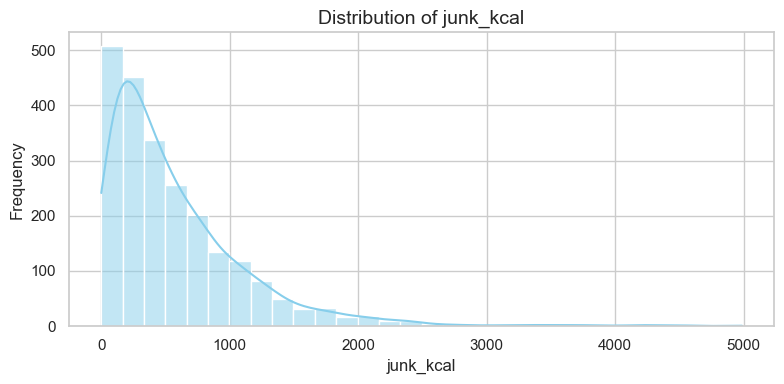

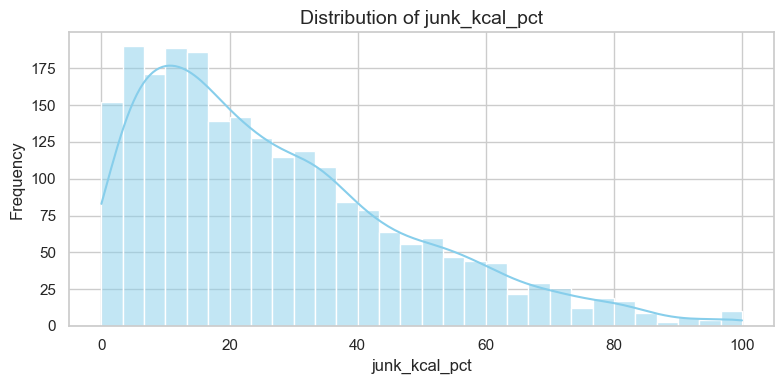

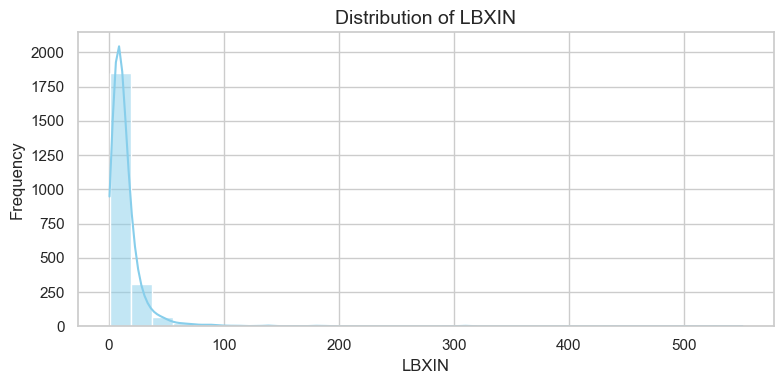

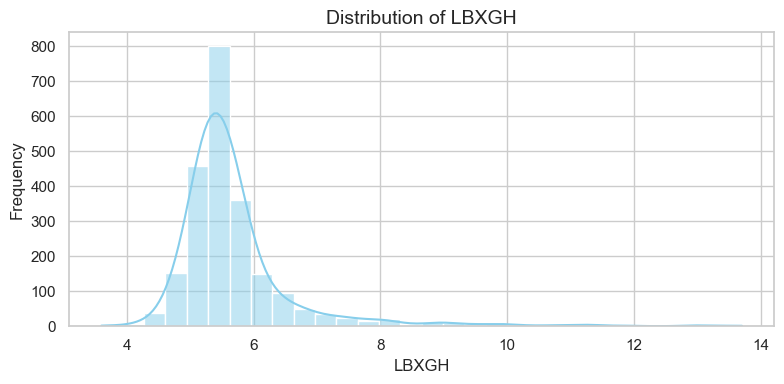

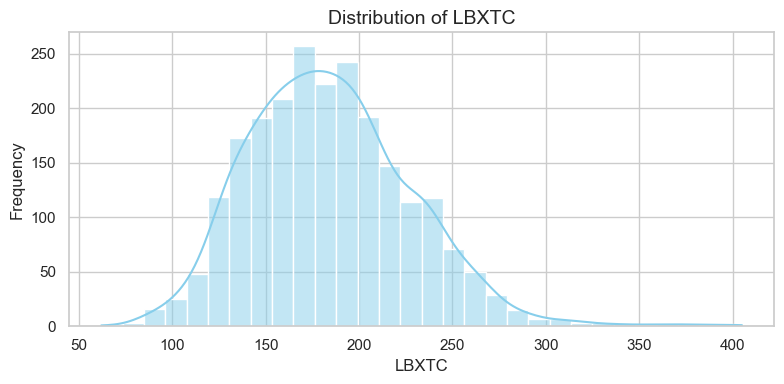

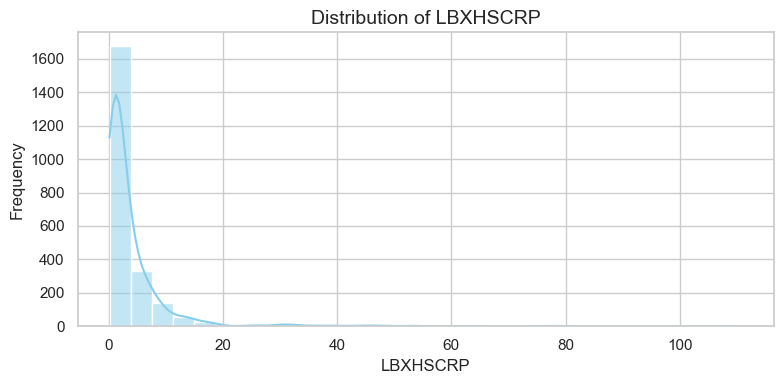

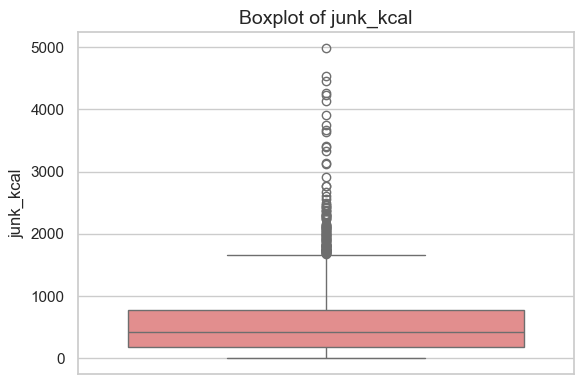

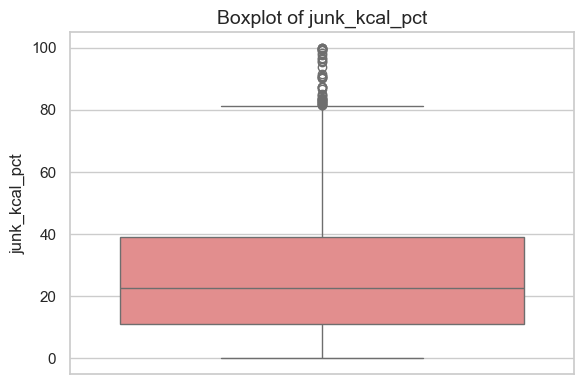

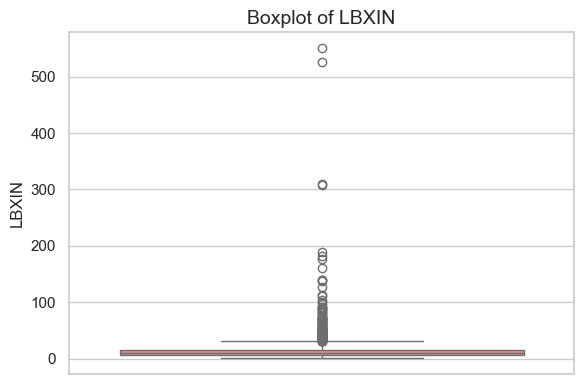

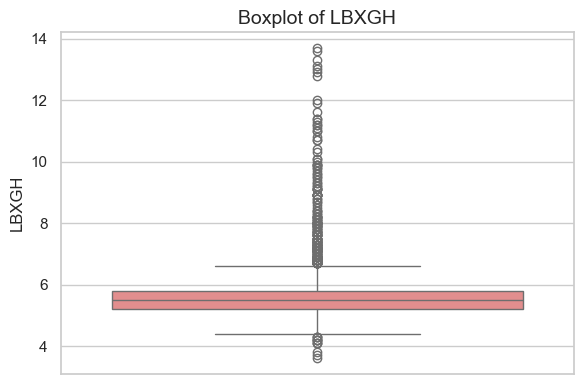

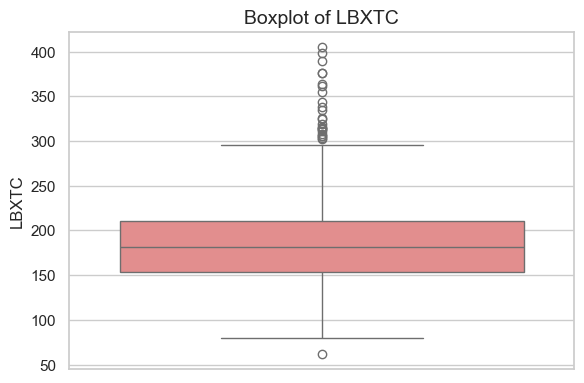

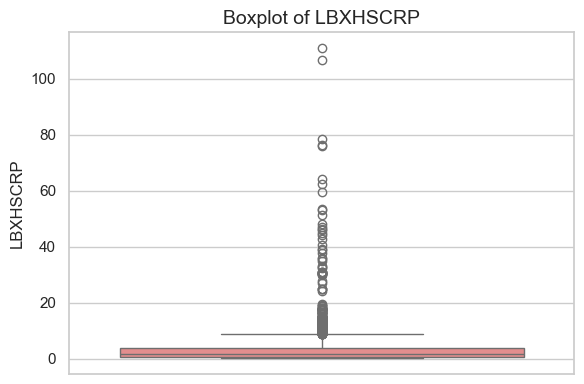

junk_kcal  junk_kcal_pct        LBXIN        LBXGH        LBXTC  \
count  2.273000e+03   2.273000e+03  2273.000000  2273.000000  2273.000000   
mean   5.756045e+02   2.738198e+01    14.448821     5.701188   184.434668   
std    5.570153e+02   2.081913e+01    23.305155     1.005317    43.562246   
min    5.397605e-79   2.161636e-80     0.350000     3.600000    62.000000   
25%    1.910000e+02   1.096394e+01     6.090000     5.200000   153.000000   
50%    4.190000e+02   2.269231e+01     9.580000     5.500000   181.000000   
75%    7.860000e+02   3.915581e+01    15.970000     5.800000   211.000000   
max    4.988000e+03   1.000000e+02   551.100000    13.700000   405.000000   

          LBXHSCRP  
count  2273.000000  
mean      3.739652  
std       7.122969  
min       0.110000  
25%       0.730000  
50%       1.670000  
75%       3.960000  
max     110.980000

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")

# Variables to explore
columns_to_plot = ['junk_kcal', 'junk_kcal_pct', 'LBXIN', 'LBXGH', 'LBXTC', 'LBXHSCRP']

# 1. Histograms with KDE
for col in columns_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_clean[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# 2. Boxplots
for col in columns_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_clean[col], color='lightcoral')
    plt.title(f'Boxplot of {col}', fontsize=14)
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# 3. Descriptive statistics
df_clean[columns_to_plot].describe()


In [154]:
import statsmodels.api as sm
import pandas as pd

# Define outcome variables and predictor
outcomes = ['LBXIN', 'LBXGH', 'LBXTC', 'LBXHSCRP']
predictor = 'junk_kcal_pct'

# Store regression results
regression_results = []

# Run OLS regression for each outcome
for outcome in outcomes:
    X = sm.add_constant(df_clean[predictor])  # Add intercept
    y = df_clean[outcome]
    model = sm.OLS(y, X).fit()
    
    result = {
        'Dependent Variable': outcome,
        'Coefficient': round(model.params[predictor], 4),
        'P-value': round(model.pvalues[predictor], 4),
        'R-squared': round(model.rsquared, 4),
        'Intercept': round(model.params['const'], 4)
    }
    regression_results.append(result)

# Display results as DataFrame
regression_summary = pd.DataFrame(regression_results)
regression_summary


Dependent Variable  Coefficient  P-value  R-squared  Intercept
0              LBXIN       0.0646   0.0059     0.0033    12.6793
1              LBXGH      -0.0004   0.7082     0.0001     5.7116
2              LBXTC      -0.1081   0.0138     0.0027   187.3951
3           LBXHSCRP       0.0072   0.3132     0.0004     3.5414

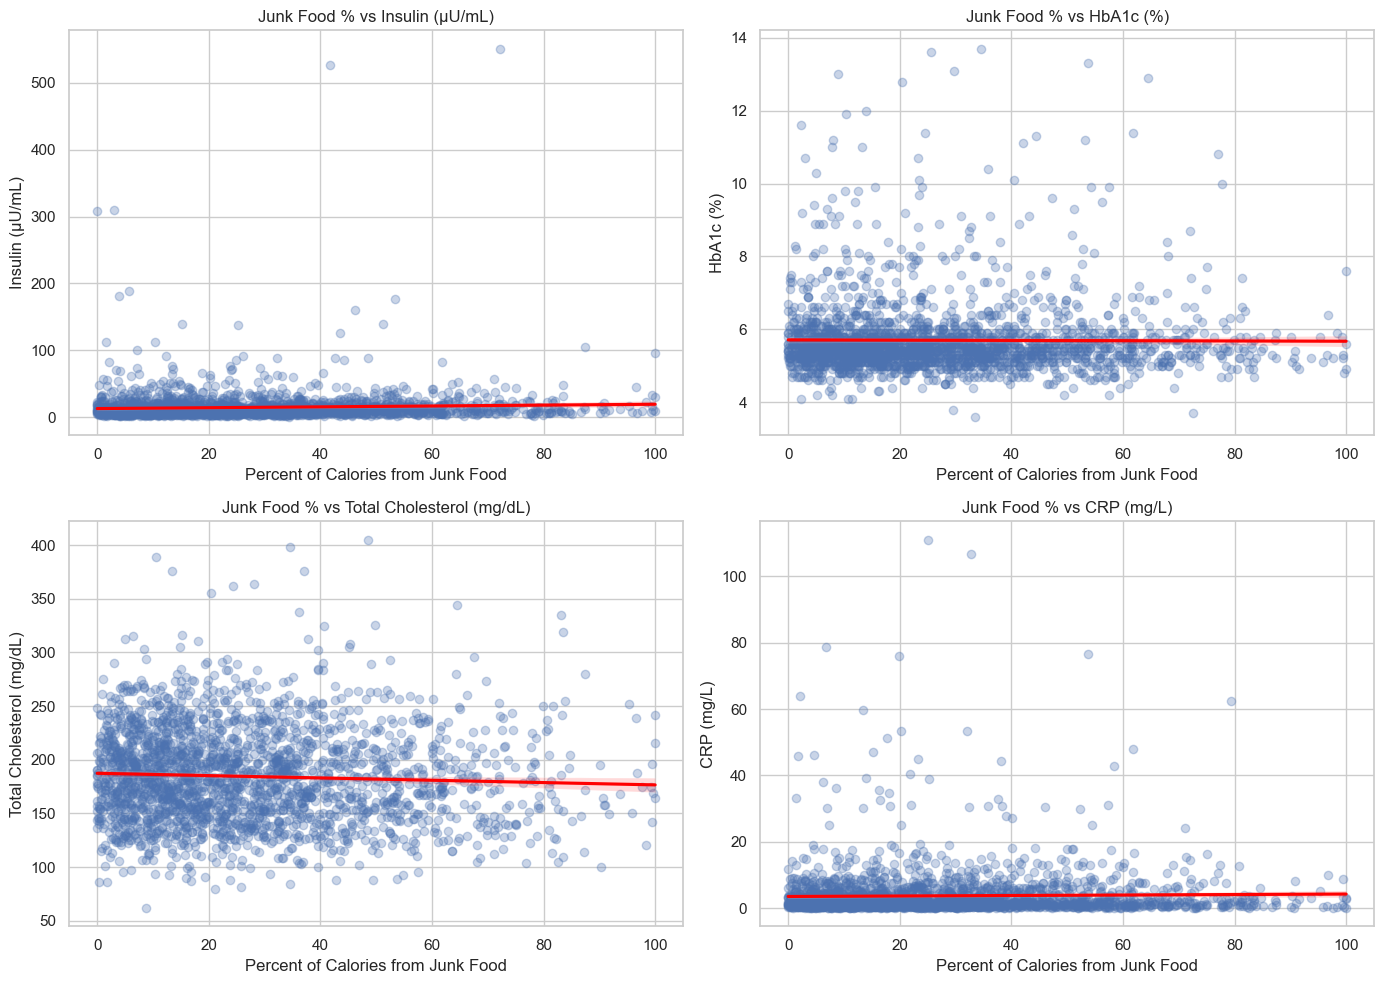

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure plot style
sns.set(style="whitegrid")

# Define outcome variables and titles for display
outcomes = ['LBXIN', 'LBXGH', 'LBXTC', 'LBXHSCRP']
titles = ['Insulin (µU/mL)', 'HbA1c (%)', 'Total Cholesterol (mg/dL)', 'CRP (mg/L)']

# Create 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, outcome in enumerate(outcomes):
    row = i // 2
    col = i % 2
    sns.regplot(
        data=df_clean,
        x='junk_kcal_pct',
        y=outcome,
        ax=axs[row][col],
        line_kws={"color": "red"},
        scatter_kws={"alpha": 0.3}
    )
    axs[row][col].set_title(f'Junk Food % vs {titles[i]}', fontsize=12)
    axs[row][col].set_xlabel('Percent of Calories from Junk Food')
    axs[row][col].set_ylabel(titles[i])

plt.tight_layout()
plt.show()
